# Auto Braking Car Controller

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

import ipywidgets as widgets
from ipywidgets import interact
%matplotlib inline

## Input and Output Variable

In [2]:
# New Antecedent/Consequent objects hold universe variables and membership
# * Distance on subjective range [0,100] in unit of kilometers
# * Distance on subjective range [0,1] in units of meters
# * Braking has a range of [0,1] in units of percentage points
x_speed = np.arange(40,110,10)
x_distance = np.arange(1,11,1)
x_braking = np.arange(0,1.1,0.1)

#Generate fuzzy membership function
#Speed (Input)
speed_lo = fuzz.trapmf(x_speed, [0,0,50,70])
speed_md = fuzz.trimf(x_speed, [50,70,90])
speed_hi = fuzz.trapmf(x_speed, [70,90,100,100])

#Distance (Input)
distance_rcl = fuzz.trimf(x_distance,[0,0,5])
distance_cl = fuzz.trimf(x_distance,[2.5,5,7.5])
distance_f = fuzz.trimf(x_distance,[6,10,10])

#Braking (Output)
braking_n = fuzz.trimf(x_braking,[0,0,0.5])
braking_s = fuzz.trimf(x_braking,[0.25,0.5,0.75])
braking_h = fuzz.trimf(x_braking,[0.5,1,1])

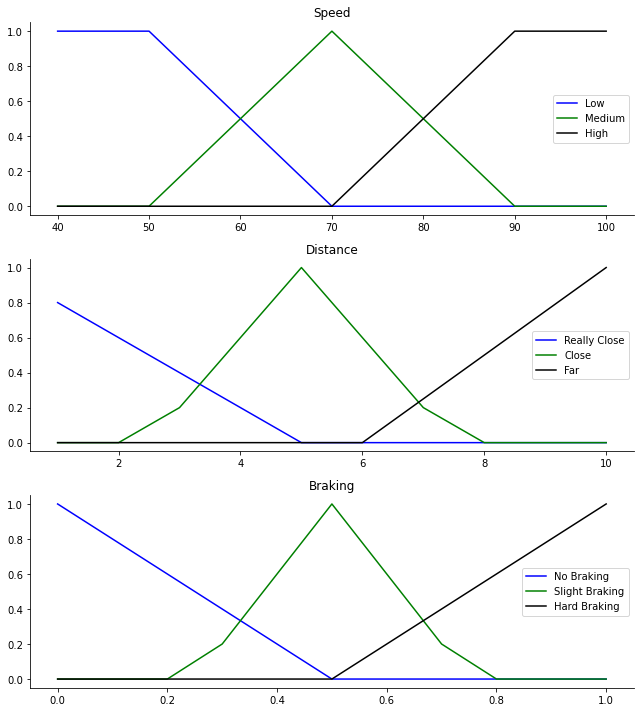

In [3]:
# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(9, 10))

ax0.plot(x_speed, speed_lo, 'b', linewidth=1.5, label='Low')
ax0.plot(x_speed, speed_md, 'g', linewidth=1.5, label='Medium')
ax0.plot(x_speed, speed_hi, 'k', linewidth=1.5, label='High')
ax0.set_title('Speed')
ax0.legend()

ax1.plot(x_distance, distance_rcl, 'b', linewidth=1.5, label='Really Close')
ax1.plot(x_distance, distance_cl, 'g', linewidth=1.5, label='Close')
ax1.plot(x_distance, distance_f, 'k', linewidth=1.5, label='Far')
ax1.set_title('Distance')
ax1.legend()

ax2.plot(x_braking, braking_n, 'b', linewidth=1.5, label='No Braking')
ax2.plot(x_braking, braking_s, 'g', linewidth=1.5, label='Slight Braking')
ax2.plot(x_braking, braking_h, 'k', linewidth=1.5, label='Hard Braking')
ax2.set_title('Braking')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

## Rule Application and Aggregation 

Consider simple rules:
1. If speed is low and the distance is far, then no braking
2. If speed is high and the distance is really close, then hard braking
3. If speed is medium and the distance is close, then slight braking
4. If speed is medium and the distance is really close, then hard braking
5. If speed is low and the distance is really close, then slight braking
6. If speed is high and the distance is close, then hard braking
7. If speed is low and the distance is close, then no braking
8. If speed is high and distance is far, then slight braking
9. If speed is medium and distance is far, then no braking

In [4]:
@interact(speed=(0, 100), distance=(1,10, 0.1))
def rule_aggregation(speed, distance):
    speed_lvl_lo = fuzz.interp_membership(x_speed, speed_lo, speed)
    speed_lvl_md = fuzz.interp_membership(x_speed, speed_md, speed)
    speed_lvl_hi = fuzz.interp_membership(x_speed, speed_hi, speed)
    
    distance_lvl_rcl = fuzz.interp_membership(x_distance, distance_rcl, distance)
    distance_lvl_cl = fuzz.interp_membership(x_distance, distance_cl, distance)
    distance_lvl_f = fuzz.interp_membership(x_distance, distance_f, distance)
    
    #Rule 1 concerns low speed AND far distance. 
    rule1_active = np.fmin(speed_lvl_lo,distance_lvl_f) #The AND operator means we take the minimum of these two
    braking_rule_1 = np.fmin(rule1_active, braking_n)

    #Rule 2 concerns high speed AND really close distance
    rule2_active = np.fmin(speed_lvl_hi,distance_lvl_rcl) #The AND operator means we take the minimum of these two
    braking_rule_2 = np.fmin(rule2_active, braking_h)

    #Rule 3 concerns medium speed AND close distance
    rule3_active = np.fmin(speed_lvl_md,distance_lvl_cl) #The AND operator means we take the minimum of these two
    braking_rule_3 = np.fmin(rule3_active, braking_s)
    
    #Rule 4 concerns medium speed AND really close distance
    rule4_active= np.fmin(speed_lvl_md,distance_lvl_rcl)
    braking_rule_4 = np.fmin(rule4_active, braking_h)    
    
    #Rule 5 concerns low speed AND really close distance
    rule5_active = np.fmin(speed_lvl_lo, distance_lvl_rcl)
    braking_rule_5 = np.fmin(rule5_active, braking_s)
    
    #Rule 6 concerns high speed AND close distance
    rule6_active = np.fmin(speed_lvl_hi, distance_lvl_cl)
    braking_rule_6 = np.fmin(rule6_active, braking_h)
    
    #Rule 7 concerns low speed AND close distance
    rule7_active = np.fmin(speed_lvl_lo, distance_lvl_cl)
    braking_rule_7 = np.fmin(rule7_active,braking_n)
    
    #Rule 8 concerns high speed AND far distance
    rule8_active = np.fmin(speed_lvl_hi, distance_lvl_f)
    braking_rule_8 = np.fmin(rule8_active,braking_s)
    
    #Rule 9 concerns medium speed AND far distance
    rule9_active = np.fmin(speed_lvl_md, distance_lvl_f)
    braking_rule_9 = np.fmin(rule9_active,braking_n)
    
    braking_ex = np.zeros_like(x_braking)
    
    #Visualize
    fix,ax0 = plt.subplots(figsize =(8,3))
    
    ax0.fill_between(x_braking, braking_ex, braking_rule_1, facecolor='b',alpha=0.7)
    ax0.plot(x_braking, braking_n, 'b', linewidth=0.5, linestyle = '--')
    ax0.fill_between(x_braking, braking_ex, braking_rule_2, facecolor='g',alpha=0.7)
    ax0.plot(x_braking, braking_s, 'g', linewidth=0.5, linestyle = '--')
    ax0.fill_between(x_braking, braking_ex, braking_rule_3, facecolor='k',alpha=0.7)
    ax0.plot(x_braking, braking_h, 'k', linewidth=0.5, linestyle = '--')
    ax0.fill_between(x_braking, braking_ex, braking_rule_4, facecolor='k',alpha=0.7)
    ax0.plot(x_braking, braking_h, 'k', linewidth=0.5, linestyle = '--')
    ax0.fill_between(x_braking, braking_ex, braking_rule_5, facecolor='g',alpha=0.7)
    ax0.plot(x_braking, braking_s, 'g', linewidth=0.5, linestyle = '--')
    ax0.fill_between(x_braking, braking_ex, braking_rule_6, facecolor='k',alpha=0.7)
    ax0.plot(x_braking, braking_h, 'k', linewidth=0.5, linestyle = '--')
    ax0.fill_between(x_braking, braking_ex, braking_rule_7, facecolor='b',alpha=0.7)
    ax0.plot(x_braking, braking_n, 'b', linewidth=0.5, linestyle = '--')
    ax0.fill_between(x_braking, braking_ex, braking_rule_8, facecolor='g',alpha=0.7)
    ax0.plot(x_braking, braking_s, 'g', linewidth=0.5, linestyle = '--')
    ax0.fill_between(x_braking, braking_ex, braking_rule_9, facecolor='b',alpha=0.7)
    ax0.plot(x_braking, braking_n, 'b', linewidth=0.5, linestyle = '--')
    
    
    ax0.set_title('Output membership activity')
    
    for ax in (ax0,):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        
    plt.tight_layout()
    aggregated = braking_rule_1
    #Aggregate all three output membership functions
    for rule in [braking_rule_2,braking_rule_3,braking_rule_4,braking_rule_5,braking_rule_6,braking_rule_7,braking_rule_8,braking_rule_9]:
        aggregated = np.fmax(aggregated,rule)
    return aggregated


interactive(children=(IntSlider(value=50, description='speed'), FloatSlider(value=5.0, description='distance',…

## Defuzzification 

In [5]:
@interact(speed=(0, 100), distance=(1,10, 0.1))
def defuzzification(distance,speed):
    
    aggregated =  rule_aggregation(speed,distance)

    braking_ex = np.zeros_like(x_braking)

    # Calculate defuzzified result
    braking = fuzz.defuzz(x_braking, aggregated, 'centroid')
    braking_activation = fuzz.interp_membership(x_braking, aggregated, braking) #for plot

    #Visualize
    fix, ax0 = plt.subplots(figsize=(9,4))

    ax0.plot(x_braking, braking_n,'b', linewidth = 0.5, linestyle = '--')
    ax0.plot(x_braking, braking_s,'g', linewidth = 0.5, linestyle = '--')
    ax0.plot(x_braking, braking_h,'k', linewidth = 0.5, linestyle = '--')
    ax0.fill_between(x_braking, braking_ex,aggregated,facecolor='Yellow', alpha =0.7)
    ax0.plot([braking,braking],[0,braking_activation],'k',linewidth=1.5,alpha=0.9)
    ax0.set_title('Agregated membership and result(line)')

    # Turn off top/right axes
    for ax in (ax0,):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()

    plt.tight_layout()
    return braking

interactive(children=(FloatSlider(value=5.0, description='distance', max=10.0, min=1.0), IntSlider(value=50, d…